In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow import Tensor
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, \
                         AveragePooling1D, GlobalAveragePooling1D, \
                         Add, BatchNormalization, ReLU, Input
                         
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters



# plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
# %matplotlib widget
# %matplotlib inline

tf.random.set_seed(18)
np.random.seed(48)

2022-02-28 05:08:29.099572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/impi/2018.4.274/compilers_and_libraries/linux/mpi/lib64:/opt/intel/impi/2018.4.274/compilers_and_libraries/linux/mpi/lib:/opt/intel/Compiler/19.0/1.144/rwthlnk/daal/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/daal/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/ipp/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/ipp/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/mkl/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/mkl/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/tbb/lib/intel64_lin/gcc4.7:/opt/intel/Compiler/19.0/1.144/rwthlnk/tbb/lib/ia32_lin/gcc4.7:/opt/intel/Compiler/19.0/1.144/rwthlnk/compiler/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/compiler/lib/ia32_lin
2022-02-28 05:08:29

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Data Import

In [3]:
with open('_pickles/exp_validation_data.pickle', 'rb') as f:
    ex_val_data = pickle.load(f)
with open('_pickles/exp_validation_labels.pickle', 'rb') as f:
    ex_val_labels = pickle.load(f)
with open('_pickles/exp_validation_trails.pickle', 'rb') as f:
    ex_val_trails = pickle.load(f)

with open('_pickles/exp_val_resample.pickle', 'rb') as f:
    ex_val_resample = pickle.load(f)
with open('_pickles/exp_val_norm_labels.pickle', 'rb') as f:
    ex_val_norm_labels = pickle.load(f)

In [4]:
with open('_pickles/train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)

with open('_pickles/train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)

with open('_pickles/training_labels.pickle', 'rb') as f:
    training_labels = pickle.load(f)

X = np.array(train_resample)
y = training_labels

scalar = MinMaxScaler()
y_norm = scalar.fit_transform(training_labels)

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

(925, 100, 4) (925, 2)
Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


#### Other Networks

##### ResNet

In [ ]:
def bn_relu(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(i)
    return j

def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = bn_relu(y)
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = bn_relu(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    out = Add()([x, y])
    # out = bn_relu(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 64
    
    # t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(inputs)
    t = bn_relu(t)
        
    num_blocks_list = [4, 2, 2, 4]
    for j in range(num_blocks_list[0]):
        t = residual_block(t, filters=num_filters)

    t = Dropout(0.25)(t)

    t = CNN_block(t, filters = 128)
    for j in range(num_blocks_list[1]):
        t = residual_block(t, filters=128)

    t = CNN_block(t, filters = 128)
    for j in range(num_blocks_list[2]):
        t = residual_block(t, filters=128)
    
    t = Dropout(0.3)(t)

    t = CNN_block(t, filters = 64)
    for j in range(num_blocks_list[3]):
        t = residual_block(t, filters=64)
    
    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    # t = Dense(units=128, activation='relu')(t)
    t = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['Accuracy']
    )

    return model

rnet = create_res_net() # or create_plain_net()
rnet.summary()

In [27]:
def relu_bn(inputs: Tensor) -> Tensor:
    bn = BatchNormalization()(inputs)
    relu = ReLU()(bn)
    return relu

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(i)
    return j

def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 64
    
    # t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(inputs)
    t = relu_bn(t)
        
    num_blocks_list = [4, 2, 2, 4]
    for j in range(num_blocks_list[0]):
        t = residual_block(t, filters=num_filters)

    t = Dropout(0.25)(t)

    t = CNN_block(t, filters = 128)
    for j in range(num_blocks_list[1]):
        t = residual_block(t, filters=128)

    t = CNN_block(t, filters = 128)
    for j in range(num_blocks_list[2]):
        t = residual_block(t, filters=128)
    
    t = Dropout(0.3)(t)

    t = CNN_block(t, filters = 64)
    for j in range(num_blocks_list[3]):
        t = residual_block(t, filters=64)
    
    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    # t = Dense(units=128, activation='relu')(t)
    t = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['Accuracy']
    )

    return model

rnet = create_res_net() # or create_plain_net()
rnet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 4)]     0           []                               
                                                                                                  
 conv1d_73 (Conv1D)             (None, 100, 64)      832         ['input_6[0][0]']                
                                                                                                  
 re_lu_63 (ReLU)                (None, 100, 64)      0           ['conv1d_73[0][0]']              
                                                                                                  
 batch_normalization_74 (BatchN  (None, 100, 64)     256         ['re_lu_63[0][0]']               
 ormalization)                                                                              

In [28]:
# timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

# checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.system('mkdir {}'.format(checkpoint_dir))

# # save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

rNet_history = rnet.fit(
    x=x_train,
    y=y_train,
    epochs=40,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=32,
    # callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/60
26/26 [==============================] - 8s 103ms/step - loss: 0.4159 - Accuracy: 0.5108 - val_loss: 0.1343 - val_Accuracy: 0.5484
Epoch 2/60
26/26 [==============================] - 2s 76ms/step - loss: 0.1674 - Accuracy: 0.5252 - val_loss: 0.1339 - val_Accuracy: 0.5269
Epoch 3/60
26/26 [==============================] - 2s 78ms/step - loss: 0.1267 - Accuracy: 0.5517 - val_loss: 0.2903 - val_Accuracy: 0.5484
Epoch 4/60
26/26 [==============================] - 2s 77ms/step - loss: 0.0920 - Accuracy: 0.5986 - val_loss: 0.1285 - val_Accuracy: 0.5484
Epoch 5/60
26/26 [==============================] - 2s 79ms/step - loss: 0.0732 - Accuracy: 0.6394 - val_loss: 0.1050 - val_Accuracy: 0.5484
Epoch 6/60
26/26 [==============================] - 2s 79ms/step - loss: 0.0599 - Accuracy: 0.6923 - val_loss: 0.1045 - val_Accuracy: 0.5806
Epoch 7/60
26/26 [==============================] - 2s 82ms/step - loss: 0.0423 - Accuracy: 0.7680 - val_loss: 0.1708 - val_Accuracy: 0.5484
Epoch 8/60
2

In [29]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(rnet.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(rnet.predict(x_test)))

115.86161827038524

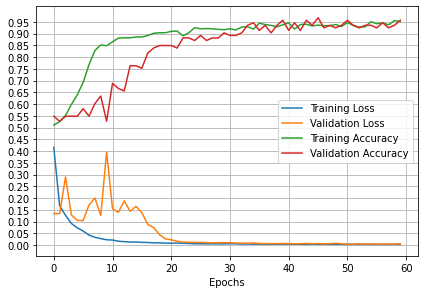

In [30]:
plt.close()
plt.plot(rNet_history.history['loss'], label='Training Loss')
plt.plot(rNet_history.history['val_loss'], label='Validation Loss')
plt.plot(rNet_history.history['Accuracy'], label='Training Accuracy')
plt.plot(rNet_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# rnet.save('ResNet-60MSE.h5')

##### Wide ResNet

In [5]:
# Wide ResNet Architecture
# https://arxiv.org/pdf/1605.07146.pdf
#
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def CNN_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    i = BatchNormalization()(x)
    j = Conv1D(kernel_size=3,
            strides=1,
            filters=filters,
            padding="same")(i)
    return j

def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv1D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv1D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(100,4))
    num_filters = 512
    
    t = BatchNormalization()(inputs)
    t = Conv1D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    #------------------------------------
    num_blocks_list = [1, 2, 1]
    for j in range(num_blocks_list[0]):
        t = residual_block(t, filters=num_filters)
    #------------------------------------
    t = Dropout(0.3)(t)

    t = CNN_block(t, filters = 32)
    for j in range(num_blocks_list[1]):
        t = residual_block(t, filters=32)
    #------------------------------------
    t = Dropout(0.3)(t)
    
    t = CNN_block(t, filters = 256)
    for j in range(num_blocks_list[2]):
        t = residual_block(t, filters=256)
    #------------------------------------

    t = AveragePooling1D(pool_size = 3)(t)
    t = Flatten()(t)
    # t = Dense(units=128, activation='relu')(t)
    t1 = Dense(units=32, activation="relu")(t)
    outputs = Dense(2, activation='linear')(t1)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='Adam',
        loss='mse',
        metrics=['Accuracy']
    )

    return model

wrnet = create_res_net() # or create_plain_net()
wrnet.summary()


2022-02-28 05:09:23.324253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/impi/2018.4.274/compilers_and_libraries/linux/mpi/lib64:/opt/intel/impi/2018.4.274/compilers_and_libraries/linux/mpi/lib:/opt/intel/Compiler/19.0/1.144/rwthlnk/daal/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/daal/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/ipp/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/ipp/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/mkl/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/mkl/lib/ia32_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/tbb/lib/intel64_lin/gcc4.7:/opt/intel/Compiler/19.0/1.144/rwthlnk/tbb/lib/ia32_lin/gcc4.7:/opt/intel/Compiler/19.0/1.144/rwthlnk/compiler/lib/intel64_lin:/opt/intel/Compiler/19.0/1.144/rwthlnk/compiler/lib/ia32_lin
2022-02-28 05:09:23.324314: W

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 4)]     0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 4)      16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 100, 512)     6656        ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 100, 512)     0           ['conv1d[0][0]']             

In [7]:
# timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

# checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.system('mkdir {}'.format(checkpoint_dir))

# # save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

wrNet_history = wrnet.fit(
    x=x_train,
    y=y_train,
    epochs=60,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=32,
    # callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/60
26/26 [==============================] - 4s 87ms/step - loss: 0.4582 - Accuracy: 0.5445 - val_loss: 0.3832 - val_Accuracy: 0.5376
Epoch 2/60
26/26 [==============================] - 2s 91ms/step - loss: 0.0973 - Accuracy: 0.5793 - val_loss: 0.4364 - val_Accuracy: 0.4731
Epoch 3/60
26/26 [==============================] - 2s 70ms/step - loss: 0.0572 - Accuracy: 0.6502 - val_loss: 0.4244 - val_Accuracy: 0.4731
Epoch 4/60
26/26 [==============================] - 2s 73ms/step - loss: 0.0314 - Accuracy: 0.7596 - val_loss: 0.3957 - val_Accuracy: 0.4946
Epoch 5/60
26/26 [==============================] - 2s 76ms/step - loss: 0.0204 - Accuracy: 0.8209 - val_loss: 0.4161 - val_Accuracy: 0.5269
Epoch 6/60
26/26 [==============================] - 2s 73ms/step - loss: 0.0149 - Accuracy: 0.8570 - val_loss: 0.4388 - val_Accuracy: 0.5484
Epoch 7/60
26/26 [==============================] - 2s 79ms/step - loss: 0.0102 - Accuracy: 0.8810 - val_loss: 0.4176 - val_Accuracy: 0.5161
Epoch 8/60
26

In [8]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wrnet.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(wrnet.predict(x_test)))

47.56131576668092

In [ ]:
# wresnet.save(f'model/wresnet_CNN_val_acc_97_16_MSE.{int(time.time())}.h5')

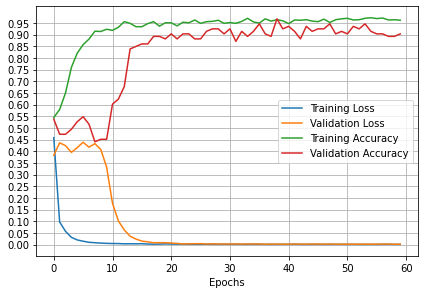

In [9]:
plt.close()
plt.plot(wrNet_history.history['loss'], label='Training Loss')
plt.plot(wrNet_history.history['val_loss'], label='Validation Loss')
plt.plot(wrNet_history.history['Accuracy'], label='Training Accuracy')
plt.plot(wrNet_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Predict experimental data validation

In [ ]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('Alex3.h5')
# model = tf.keras.models.load_model('model/CNN_val_acc_96_48_MSEperAcc.1642513870.h5')
# model.summary()

In [ ]:
y_pred = rnet.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels

y_pred = scalar.inverse_transform(np.asarray(y_pred))
diff = y_abs-y_pred
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

In [ ]:
mean_squared_error(y_abs, y_pred, squared=True)
# mean_absolute_error(y_abs, y_pred)